In [9]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

First, determine samples to use and gender of the samples. Uses Vasili's cov files.

In [10]:
cov_summaries = glob.glob("/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/Pongo_pygmaeus_ssp/cov/*")
df_l = []
for p in cov_summaries:
    df = pd.read_csv(p, sep="\t", names=["Name", "Contig", "start", "end", "length", "?", "coverage"])
    df["ID"] = p.split("/")[-1].split(".")[0]
    df_l.append(df)
df_cov = pd.concat(df_l)

In [11]:
df_cov["Contig_type"] = ["chrX" if x == "postPAR1" else "non-X" for x in df_cov.Name]
df_group = df_cov.groupby(["ID", "Contig_type"])["coverage"].median().reset_index()
non_X = df_group.loc[df_group.Contig_type == "non-X"]
df_cov["aut_cov"] = df_cov.ID.map(dict(zip(non_X.ID, non_X.coverage)))
df_cov["relative_cov"] = df_cov.coverage/df_cov.aut_cov

Use this df to create two sample cohorts, male and female.

In [12]:
df_x_only = df_cov.loc[df_cov.Contig_type == "chrX"]
df_x_only["Sex"] = [0 if x <= 0.75 else 1 for x in df_x_only.relative_cov]

/tmp/60694610/ipykernel_3983285/1432902879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_only["Sex"] = [0 if x <= 0.75 else 1 for x in df_x_only.relative_cov]


In [13]:
ds = sg.load_dataset("../data/Pongo_pygmaeus")
ds["sample_cohort"] = xr.DataArray(pd.Series(ds.sample_id.values).map(dict(zip(df_x_only.ID,df_x_only.Sex
                                                                              ))), dims="samples")

In [14]:
pd.Series(ds["variant_contig"]).unique() #unique or value_counts to determine contigs with data in them.

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int8)

In [15]:
missing_rate = ds.call_genotype_mask[:,:,0].sum(axis=0).values/ds.call_genotype_mask[:,:,0].count(axis=0).values

In [16]:
missing_rate

array([0.00356532, 0.12019742, 0.00468023, 0.00582316, 0.00603939,
       0.00572286, 0.00465782, 0.46306882, 0.01698236, 0.04378497,
       0.13073036, 0.17931166, 0.85732405, 0.89678975, 0.94251531,
       0.80218556, 0.07067866, 0.05004024, 0.07024316, 0.04643451,
       0.03272449])

[Text(0, 0.5, 'Missing Rate'), Text(0.5, 0, 'Autosomal Coverage')]

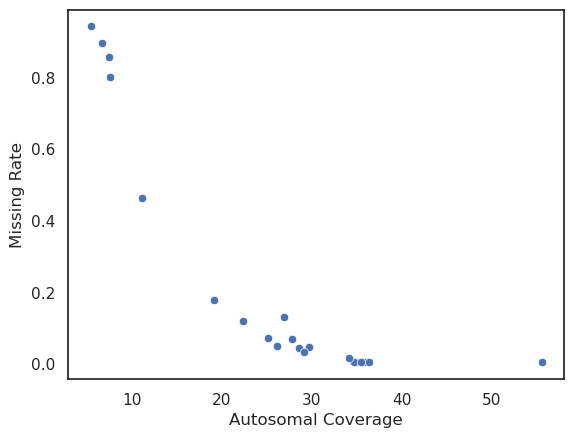

In [17]:
g = sns.scatterplot(y=missing_rate,
                x=df_x_only.loc[df_x_only.ID.isin(ds.sample_id.values)].sort_values(by="ID").aut_cov)
g.set(ylabel="Missing Rate", xlabel="Autosomal Coverage")

In [18]:
test_df = pd.DataFrame({"Missing": missing_rate,
               "Aut_cov": df_x_only.loc[df_x_only.ID.isin(ds.sample_id.values)].sort_values(by="ID").aut_cov,
             "ID": ds.sample_id.values}).sort_values(by="Aut_cov")

In [19]:
test_df["Seq_line"] = ["PD" if x[:1]=="P" else "SAMN" for x in test_df.ID]

[Text(0, 0.5, 'Missing Rate'), Text(0.5, 0, 'Autosomal Coverage')]

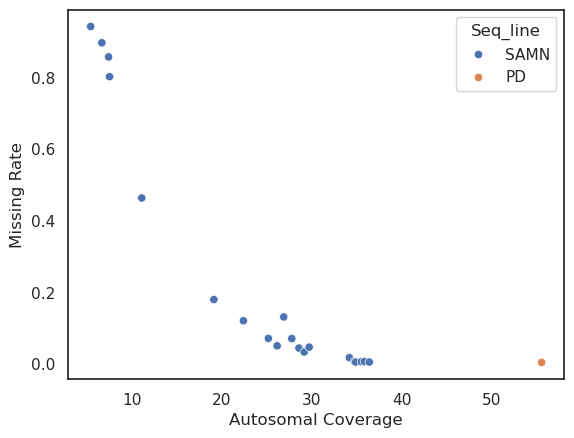

In [20]:
g = sns.scatterplot(test_df, y="Missing", x="Aut_cov", hue="Seq_line")
g.set(ylabel="Missing Rate", xlabel="Autosomal Coverage")

In [24]:
# Step to handle my issues - remove empty contigs, that is contigs without any variants.
dstest = ds.sel(contigs=pd.Series(ds["variant_contig"]).unique())
IDs_to_keep = df_x_only.loc[df_x_only.aut_cov >= 20].ID
df_i_ID = pd.DataFrame({"ds_index": ds.samples, "ID": ds.sample_id})
dstest = dstest.sel(samples=df_i_ID.loc[df_i_ID.ID.isin(IDs_to_keep)].ds_index.values)

In [25]:
dstest

<xarray.Dataset> Size: 2GB
Dimensions:               (variants: 17666860, samples: 15, ploidy: 2,
                           contigs: 24, filters: 2, region_index_values: 17690,
                           region_index_fields: 6, alleles: 2)
Coordinates:
  * samples               (samples) int64 120B 0 1 2 3 4 5 ... 10 16 17 18 19 20
Dimensions without coordinates: variants, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 530MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 530MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 265MB dask.array<chunksize=(1000, 15), meta=np.ndarray>
    contig_id             (contigs) object 192B dask.array<chunksize=(24,), meta=np.ndarray>
    contig_length         (contigs) float64 192B dask.array<chunksize=(24,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 141MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 18MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 35MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 71MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 71MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 120B 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [32]:
# Going to use 10000 position windows as filtering is not that easy without a coverage map.
window_size = 5000
ds_w = sg.window_by_position(dstest, size=window_size)
ds_d = sg.diversity(ds_w) # It crashes on very large windows, but works in the 1k-10k range.

In [33]:
# Note how I generate a new coordinate to filter/plot by, and make sure to add the relevant dimensions to it.
window_starts_bp = pd.DataFrame({"window_contig":ds_d.window_contig}).groupby("window_contig").cumcount().values*window_size
ds_d["w_s_bp"] = (["windows"], window_starts_bp)
ds_d

<xarray.Dataset> Size: 3GB
Dimensions:               (windows: 634120, cohorts: 2, variants: 17666860,
                           alleles: 2, samples: 15, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 17690,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 120B 0 1 2 3 4 5 ... 10 16 17 18 19 20
Dimensions without coordinates: windows, cohorts, variants, alleles, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields
Data variables: (12/24)
    stat_diversity        (windows, cohorts) float64 10MB dask.array<chunksize=(37, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 565MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 530MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    window_contig         (windows) int64 5MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
    window_start          (windows) int64 5MB 0 0 0 ... 17666847 17666852
    window_stop           (windows) int64 5MB 0 0 4 ... 17666852 17666860
    ...                    ...
    variant_id_mask       (variants) bool 18MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 35MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 71MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 71MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 120B 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0
    w_s_bp                (windows) int64 5MB 0 5000 ... 160950000 160955000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [34]:
ds_d

<xarray.Dataset> Size: 3GB
Dimensions:               (windows: 634120, cohorts: 2, variants: 17666860,
                           alleles: 2, samples: 15, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 17690,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 120B 0 1 2 3 4 5 ... 10 16 17 18 19 20
Dimensions without coordinates: windows, cohorts, variants, alleles, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields
Data variables: (12/24)
    stat_diversity        (windows, cohorts) float64 10MB dask.array<chunksize=(37, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 565MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 530MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    window_contig         (windows) int64 5MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
    window_start          (windows) int64 5MB 0 0 0 ... 17666847 17666852
    window_stop           (windows) int64 5MB 0 0 4 ... 17666852 17666860
    ...                    ...
    variant_id_mask       (variants) bool 18MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 35MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 71MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 71MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 120B 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0
    w_s_bp                (windows) int64 5MB 0 5000 ... 160950000 160955000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [35]:
ds_vi = ds_d.set_index(variants=("variant_contig", "variant_position"))

In [36]:
div_stats_x = ds_vi.sel(variant_contig = 23)["stat_diversity"].values

[(-1.0, 75.0), Text(0.5, 1.0, 'Diversity per 10k')]

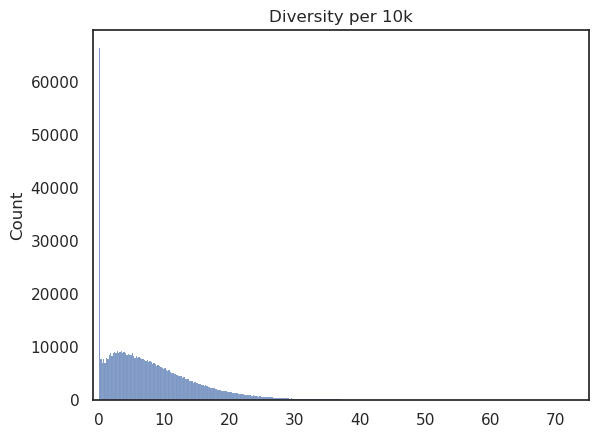

In [37]:
g = sns.histplot(div_stats_x[:,0])
g.set(xlim=(-1, 75), title="Diversity per 10k")

<Axes: ylabel='Count'>

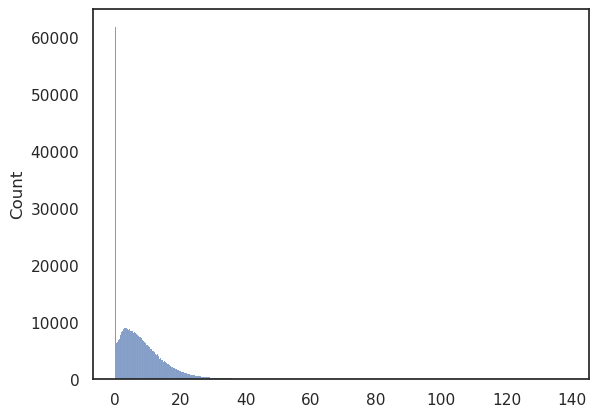

In [38]:
sns.histplot(div_stats_x[:,1])

In [39]:
ds_vi

<xarray.Dataset> Size: 3GB
Dimensions:               (windows: 634120, cohorts: 2, variants: 17666860,
                           alleles: 2, samples: 15, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 17690,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 120B 0 1 2 3 4 5 ... 10 16 17 18 19 20
  * variants              (variants) object 141MB MultiIndex
  * variant_contig        (variants) int8 18MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
  * variant_position      (variants) int32 71MB 14465 14533 ... 160956250
Dimensions without coordinates: windows, cohorts, alleles, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields
Data variables: (12/22)
    stat_diversity        (windows, cohorts) float64 10MB dask.array<chunksize=(37, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 565MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 530MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    window_contig         (windows) int64 5MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
    window_start          (windows) int64 5MB 0 0 0 ... 17666847 17666852
    window_stop           (windows) int64 5MB 0 0 4 ... 17666852 17666860
    ...                    ...
    variant_id            (variants) object 141MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 18MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 35MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 71MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 120B 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0
    w_s_bp                (windows) int64 5MB 0 5000 ... 160950000 160955000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [40]:
np.nanmean(div_stats_x[:,1]), np.nanmean(div_stats_x[:,0]) # Females have a marginally higher diversity, but very similar

(7.875078097023694, 7.883791093307407)

In [41]:
# Code from the sgkit reference to find the variants that are in each window.
size_l = pd.Series([j-i for i, j in zip(ds_d.window_start[:].values,
                             ds_d.window_stop[:].values)])
# Very slow, but I do not need to extract the exact variants. Difference between index start and end is enough.
# And this is quick.

[Text(0.5, 1.0, 'Variants per window')]

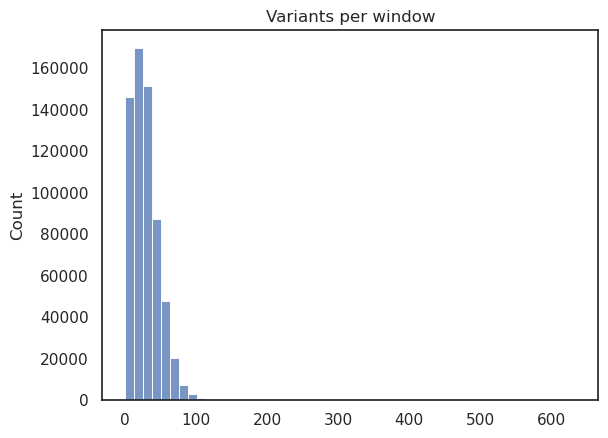

In [42]:
g = sns.histplot(size_l, bins=50)
g.set(title="Variants per window")

In [43]:
size_l.mean(), size_l.median(), size_l.quantile(0.2)

(27.860436510439666, 26.0, 11.0)

Subsetting to only use windows with at least 10 sites.
Determining whether diversity correlation is similar on chrX and autosomes across male/females.

In [44]:
ds_sites = ds_d.sel(windows = (size_l >= 10))
ds_sites = ds_sites.set_index(variants=("variant_contig", "variant_position"))

In [45]:
ds_sites

<xarray.Dataset> Size: 3GB
Dimensions:               (windows: 520166, cohorts: 2, variants: 17666860,
                           alleles: 2, samples: 15, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 17690,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 120B 0 1 2 3 4 5 ... 10 16 17 18 19 20
  * variants              (variants) object 141MB MultiIndex
  * variant_contig        (variants) int8 18MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
  * variant_position      (variants) int32 71MB 14465 14533 ... 160956250
Dimensions without coordinates: windows, cohorts, alleles, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields
Data variables: (12/22)
    stat_diversity        (windows, cohorts) float64 8MB dask.array<chunksize=(35, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 565MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 530MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    window_contig         (windows) int64 4MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
    window_start          (windows) int64 4MB 4 30 50 ... 17666638 17666736
    window_stop           (windows) int64 4MB 30 50 77 ... 17666648 17666747
    ...                    ...
    variant_id            (variants) object 141MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 18MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 35MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 71MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 120B 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0
    w_s_bp                (windows) int64 4MB 15000 20000 ... 160840000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

Diversity comparison before and after this filter.

[Text(0.5, 1.0, 'Pi per base in 10k windows')]

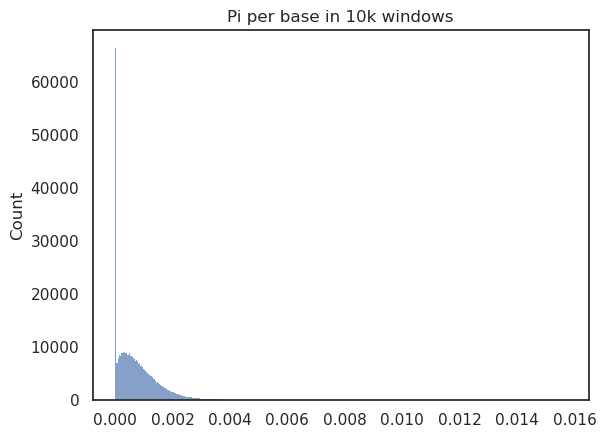

In [46]:
g = sns.histplot(ds_d["stat_diversity"][:,0]/10000)
g.set(title="Pi per base in 10k windows")

[Text(0.5, 1.0, 'Pi per base in 10k windows')]

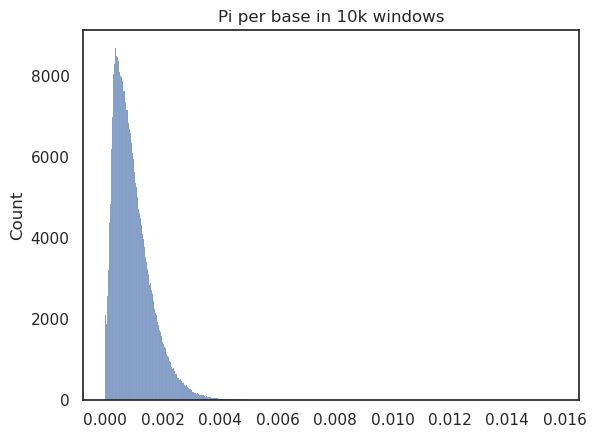

In [47]:
g = sns.histplot(ds_sites["stat_diversity"][:,0]/10000)
g.set(title="Pi per base in 10k windows")

In [73]:
df = pd.DataFrame()
for c in [13, 14, 15, 23]:
    ds_s = ds_sites.sel(variant_contig=(c))
    ds_s = ds_s.sel(contigs=(c))
    ds_s = ds_s.sel(variant_position=slice(12039749, None))
    ds_s = sg.individual_heterozygosity(ds_s)
    total_het = ds_s["call_heterozygosity"].sum(axis=0).values
    df["contig_{}_total_het".format(c)] = total_het
    df["het_per_basepair_{}".format(c)] = total_het/int(ds_s["contig_length"].values)
    df["het_per_called_site_{}".format(c)] = total_het/len(ds_s["call_heterozygosity"])

/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/sgkit/utils.py:151: DimensionWarning: Dimensions ('variant_position', 'samples', 'alleles') do not match ('variants', 'samples', 'alleles')
  warnings.warn(f"Dimensions {a.dims} do not match {dims}", DimensionWarning)
/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/sgkit/utils.py:151: DimensionWarning: Dimensions ('variant_position', 'samples', 'alleles') do not match ('variants', 'samples', 'alleles')
  warnings.warn(f"Dimensions {a.dims} do not match {dims}", DimensionWarning)
/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/sgkit/utils.py:151: DimensionWarning: Dimensions ('variant_position', 'samples', 'alleles') do not match ('variants', 'samples', 'alleles')
  warnings.warn(f"Dimensions {a.dims} do not match {dims}", DimensionWarning)
/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/sgkit/utils.py:151: DimensionWarning: Dimensio

<Axes: xlabel='het_per_basepair_14', ylabel='X_12_ratio'>

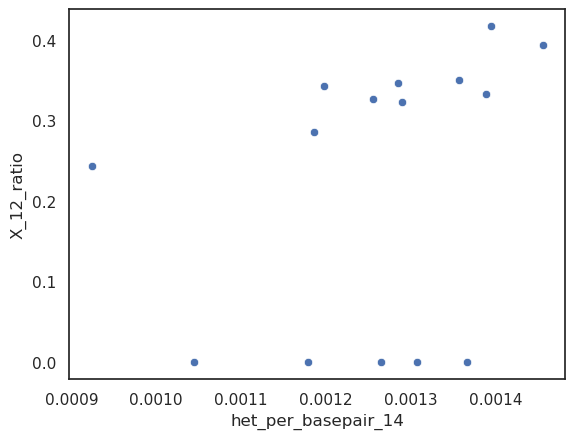

In [76]:
df["X_12_ratio"] = df["het_per_basepair_23"]/df["het_per_basepair_13"]
df["ID"] = ds_s.sample_id.values
#df["relative_cov"] = df.ID.map(dict(zip(x_cov_determination.ID, x_cov_determination.relative_cov)))
sns.scatterplot(df, y="X_12_ratio", x="het_per_basepair_14")

In [75]:
dict(zip(df_x_only.ID,df_x_only.Sex))

{'SAMEA104361538': 0,
 'SAMN00007164': 1,
 'SAMEA104361536': 0,
 'PD_0262': 1,
 'SAMN00007165': 0,
 'SAMEA104361537': 1,
 'SAMEA104361539': 0,
 'SAMEA104361542': 0,
 'SAMN01920551': 0,
 'SAMN00007166': 1,
 'SAMEA104361534': 0,
 'SAMEA104361533': 1,
 'SAMEA104361541': 1,
 'SAMN00007168': 0,
 'SAMN01920549': 1,
 'SAMN01920547': 1,
 'SAMN01920550': 1,
 'SAMN01920548': 1,
 'SAMEA104361540': 1,
 'SAMN00007167': 0,
 'SAMEA104361535': 1}

Checking correlation between maleX and femaleX. The number of windows are correct (I would imagine), but the positions are odd. It's index positions.

In [48]:
ds_sitesX = ds_sites.sel(windows=(ds_sites.window_contig == 23))

In [49]:
ds_sitesX

<xarray.Dataset> Size: 3GB
Dimensions:               (windows: 14231, cohorts: 2, variants: 17666860,
                           alleles: 2, samples: 15, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 17690,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 120B 0 1 2 3 4 5 ... 10 16 17 18 19 20
  * variants              (variants) object 141MB MultiIndex
  * variant_contig        (variants) int8 18MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
  * variant_position      (variants) int32 71MB 14465 14533 ... 160956250
Dimensions without coordinates: windows, cohorts, alleles, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields
Data variables: (12/22)
    stat_diversity        (windows, cohorts) float64 228kB dask.array<chunksize=(34, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 565MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 530MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    window_contig         (windows) int64 114kB 23 23 23 23 23 ... 23 23 23 23
    window_start          (windows) int64 114kB 17289349 17289388 ... 17666736
    window_stop           (windows) int64 114kB 17289388 17289409 ... 17666747
    ...                    ...
    variant_id            (variants) object 141MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 18MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 35MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 71MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 120B 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0
    w_s_bp                (windows) int64 114kB 50000 55000 ... 160840000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [50]:
len(ds_sitesX.window_contig)

14231

[Text(0.5, 1.0, 'Male chrX diversity'),
 Text(0, 0.5, 'Pi'),
 Text(0.5, 0, 'Window')]

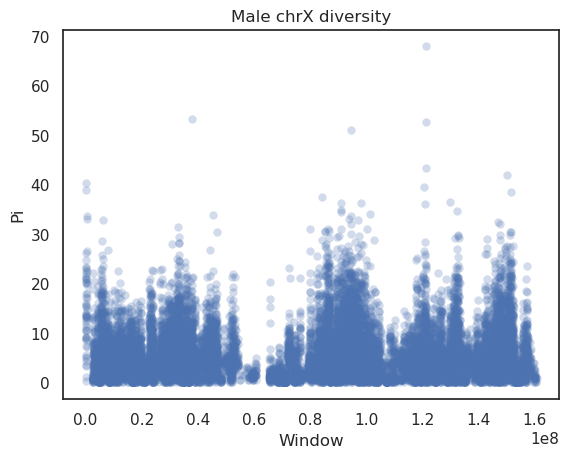

In [51]:
g = sns.scatterplot(x=ds_sitesX.w_s_bp, y=ds_sitesX.stat_diversity[:,0], alpha=0.25, linewidth=0)
g.set(title="Male chrX diversity", ylabel="Pi", xlabel="Window")

[Text(0.5, 1.0, 'Female chrX diversity'),
 Text(0, 0.5, 'Pi'),
 Text(0.5, 0, 'Window')]

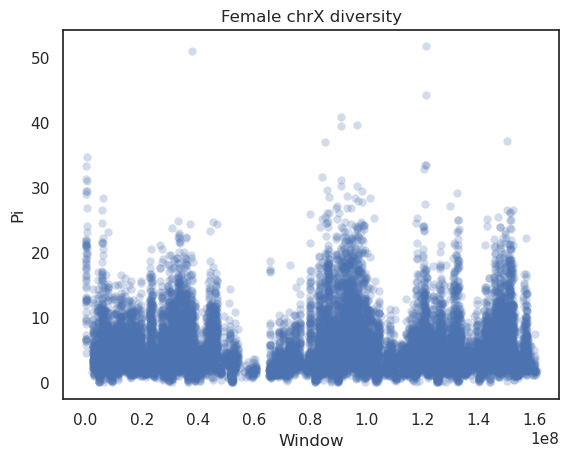

In [52]:
g = sns.scatterplot(x=ds_sitesX.w_s_bp, y=ds_sitesX.stat_diversity[:,1], alpha=0.25, linewidth=0)
g.set(title="Female chrX diversity", ylabel="Pi", xlabel="Window")

<Axes: ylabel='Count'>

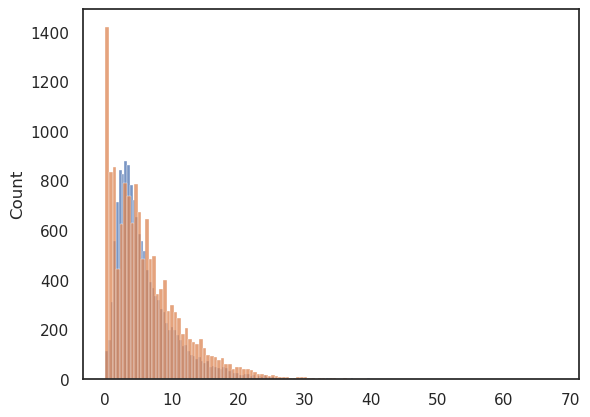

In [77]:
sns.histplot(ds_sitesX.stat_diversity[:,1])
sns.histplot(ds_sitesX.stat_diversity[:,0])

In [79]:
(ds_sitesX.stat_diversity[:,1].mean()/ds_sitesX.stat_diversity[:,0].mean()).values

array(0.97049088)

Runs of low diversity.

In [53]:
import itertools
diversity_df = pd.DataFrame({"window_start": ds_sitesX.w_s_bp, "diversity": ds_sitesX.stat_diversity[:,1]})
diversity_df["low_cut"] = diversity_df.diversity < np.quantile(ds_sitesX.stat_diversity[:,1].values, 0.5)
diversity_df["low_streak"] = [i for k, g in itertools.groupby(diversity_df["low_cut"]) for i in range(len(list(g)))]


[Text(0.5, 1.0, 'Female chrX low diversity runs'),
 Text(0, 0.5, 'Run Length'),
 Text(0.5, 0, 'Window')]

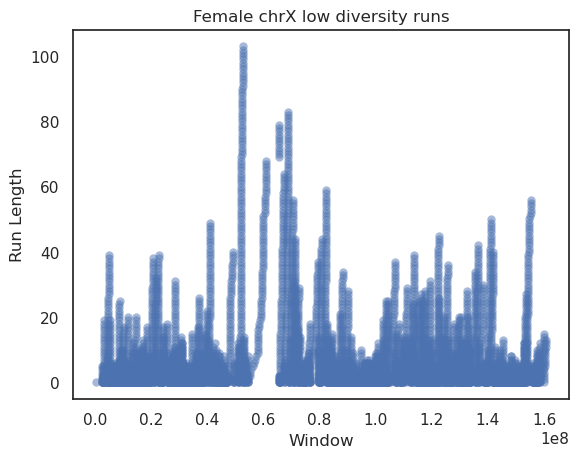

In [54]:
g = sns.scatterplot(diversity_df.loc[diversity_df.low_cut == True], x="window_start", y="low_streak", alpha=0.5, linewidth=0)
g.set(title="Female chrX low diversity runs", ylabel="Run Length", xlabel="Window")

In [55]:
diversity_df.loc[diversity_df.low_cut == True].sort_values(by="low_streak")

,window_start,diversity,low_cut,low_streak
76,2615000,3.021053,True,0
147,3125000,2.999819,True,0
149,3135000,2.273443,True,0
151,3145000,3.202433,True,0
156,3170000,3.756007,True,0
...,...,...,...,...
5104,52600000,2.956751,True,99
5105,52605000,1.951216,True,100
5106,52610000,3.320906,True,101
5107,52615000,3.647368,True,102


Garuds H.

In [56]:
ds_garud = sg.Garud_H(ds_sitesX)

[Text(0.5, 1.0, "Female chrX Garud's H12"),
 Text(0, 0.5, 'Percentage haplotypes'),
 Text(0.5, 0, 'Window')]

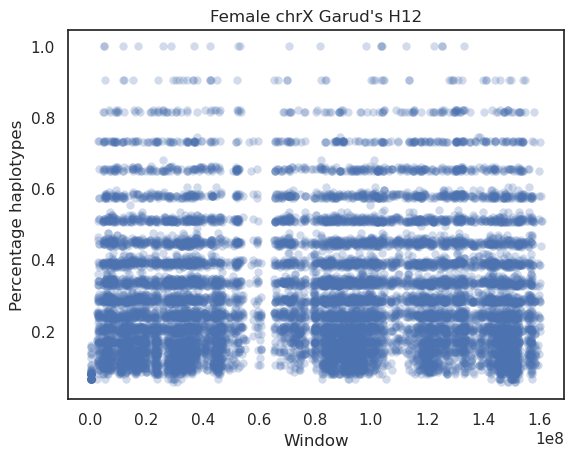

In [57]:
g = sns.scatterplot(x=ds_garud.w_s_bp[1:], y=ds_garud.stat_Garud_h12[:len(ds_garud.stat_Garud_h12)-1,1].values, alpha=0.25, linewidth=0)
g.set(title="Female chrX Garud's H12", ylabel="Percentage haplotypes", xlabel="Window")

In [58]:
ds_sites.sel(windows=(ds_sites.window_start <= 1000))

<xarray.Dataset> Size: 3GB
Dimensions:               (windows: 33, cohorts: 2, variants: 17666860,
                           alleles: 2, samples: 15, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 17690,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 120B 0 1 2 3 4 5 ... 10 16 17 18 19 20
  * variants              (variants) object 141MB MultiIndex
  * variant_contig        (variants) int8 18MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
  * variant_position      (variants) int32 71MB 14465 14533 ... 160956250
Dimensions without coordinates: windows, cohorts, alleles, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields
Data variables: (12/22)
    stat_diversity        (windows, cohorts) float64 528B dask.array<chunksize=(33, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 565MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 530MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    window_contig         (windows) int64 264B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    window_start          (windows) int64 264B 4 30 50 77 ... 803 865 933 979
    window_stop           (windows) int64 264B 30 50 77 120 ... 865 933 979 1035
    ...                    ...
    variant_id            (variants) object 141MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 18MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 35MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 71MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 120B 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0
    w_s_bp                (windows) int64 264B 15000 20000 ... 175000 180000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [59]:
ds_sites_aut = ds_sites.sel(windows=(ds_sites.window_contig != 23))

In [60]:
xr.corr(ds_sitesX.stat_diversity[:,1], ds_sitesX.stat_diversity[:,0]).values

array(0.76565308)

Brainstorm other statistics to present. Lets do some relatedness statistics.

In [61]:
c_chosen = 10
ds10 = dstest.sel(variants=(dstest.variant_contig == 10).compute())

<Axes: >

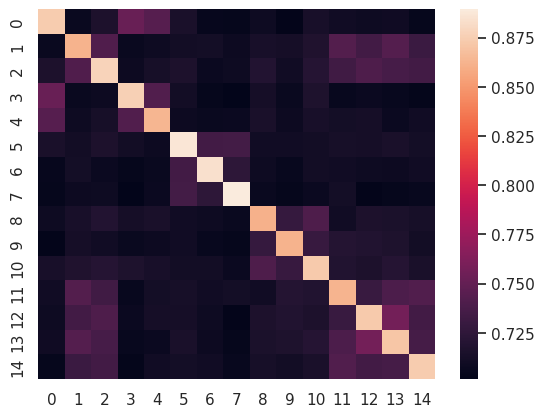

In [62]:
sns.heatmap(sg.identity_by_state(ds10)["stat_identity_by_state"].values)

In [63]:
ids_square = sg.identity_by_state(ds10)["stat_identity_by_state"].values

<Axes: ylabel='Count'>

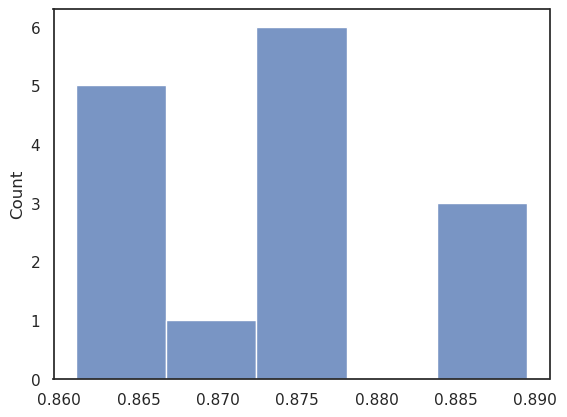

In [64]:
sns.histplot(ids_square.diagonal())

<Axes: ylabel='Count'>

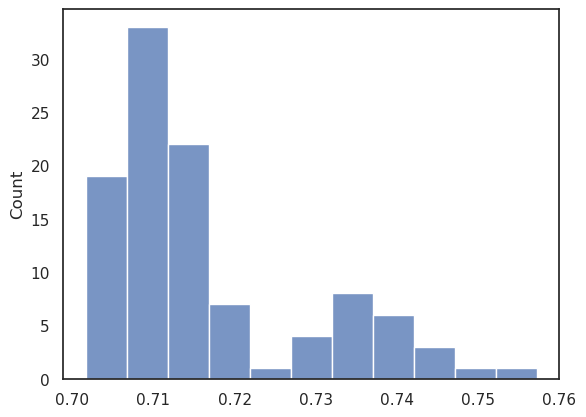

In [65]:
sns.histplot(ids_square[np.tril_indices(len(ids_square), -1)])

In [66]:
missing_rate = ds10.call_genotype_mask[:,:,1].sum(axis=1).values/ds10.call_genotype_mask[:,:,1].count(axis=1).values
ds10ss = ds10.isel(variants=(missing_rate == 0))

In [67]:
ds10ss["call_dosage"] = ds10ss["call_genotype"].sum(dim="ploidy")

<Axes: ylabel='Count'>

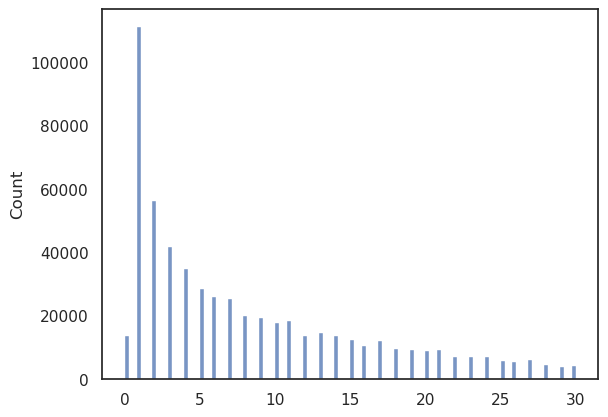

In [68]:
sns.histplot(ds10ss.call_dosage.sum(axis=1))

In [81]:
ds10ss["call_dosage"] = ds10ss["call_genotype"].sum(dim="ploidy")
ds10ss = ds10ss.isel(variants=((ds10ss.call_dosage.sum(axis=1).values >= 4)
                               & (ds10ss.call_dosage.sum(axis=1).values <= 26)))
ds10ss = sg.window_by_variant(ds10ss.drop_dims(["windows"]), size=100)
pruned_ds = sg.ld_prune(ds10ss)
pca10 = sg.pca(pruned_ds)

[Text(0.5, 0, 'PC1, Variance explained 0.12'),
 Text(0, 0.5, 'PC2, Variance explained 0.103')]

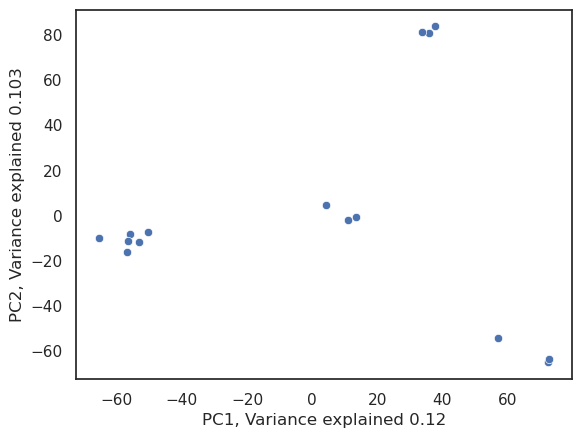

In [82]:
pcx = 0
pcy = 1
g =sns.scatterplot(x=pca10.sample_pca_projection[:,pcx], y=pca10.sample_pca_projection[:,pcy])
g.set(xlabel="PC1, Variance explained {0:.3g}".format(pca10.sample_pca_explained_variance_ratio[pcx].values),
      ylabel="PC2, Variance explained {0:.3g}".format(pca10.sample_pca_explained_variance_ratio[pcy].values))

In [83]:
pc_relate_matrix = sg.pc_relate(pca10, maf=0.1)["pc_relate_phi"].values

/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/dask/array/core.py:3488: UserWarning: Passing an object to dask.array.from_array which is already a Dask collection. This can lead to unexpected behavior.
  warnings.warn(


<Axes: >

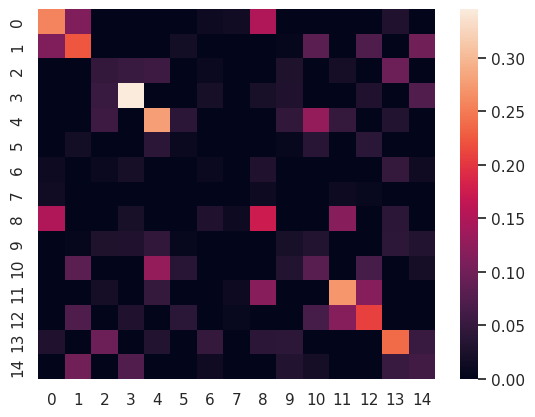

In [84]:
sns.heatmap(pc_relate_matrix.clip(min=0))
# Self should be 0.5, but is instead inferred to be 0.25-0.4 for the various individuals.

It should've calculated the self-kinship coefficient to be 0.5 on the diagonal, but instead it seems to be in the 0.25-0.4 ballpark.

In [87]:
ds_prep = pruned_ds.drop_dims(["windows"])
ds_prep["sample_cohort"] = xr.DataArray(range(len(ds_prep.sample_id)))
ds_prep = sg.window_by_genome(ds_prep)
fst_results = sg.Fst(ds_prep)
fst_results = fst_results["stat_Fst"].values
fst_results

array([[[        nan,  0.08974663,  0.10771646, -0.03776005,
         -0.03954186,  0.14741772,  0.15620473,  0.17753842,
          0.06985205,  0.08833577,  0.10587515,  0.07290922,
          0.10900588,  0.10723575,  0.11828464],
        [ 0.08974663,         nan, -0.03217724,  0.07221822,
          0.03541517,  0.11757648,  0.10430484,  0.12272617,
          0.01637753,  0.02765827,  0.05871627, -0.08471892,
          0.0035461 , -0.04622839, -0.00151707],
        [ 0.10771646, -0.03217724,         nan,  0.11716427,
          0.07362768,  0.14720812,  0.14704475,  0.16445783,
          0.04721816,  0.08323296,  0.090198  , -0.0081456 ,
          0.02511592,  0.0182561 ,  0.04052863],
        [-0.03776005,  0.07221822,  0.11716427,         nan,
         -0.03781513,  0.15243902,  0.15252806,  0.16760117,
          0.05808266,  0.08753799,  0.09974236,  0.07008567,
          0.11133603,  0.10460449,  0.118654  ],
        [-0.03954186,  0.03541517,  0.07362768, -0.03781513,
           

/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


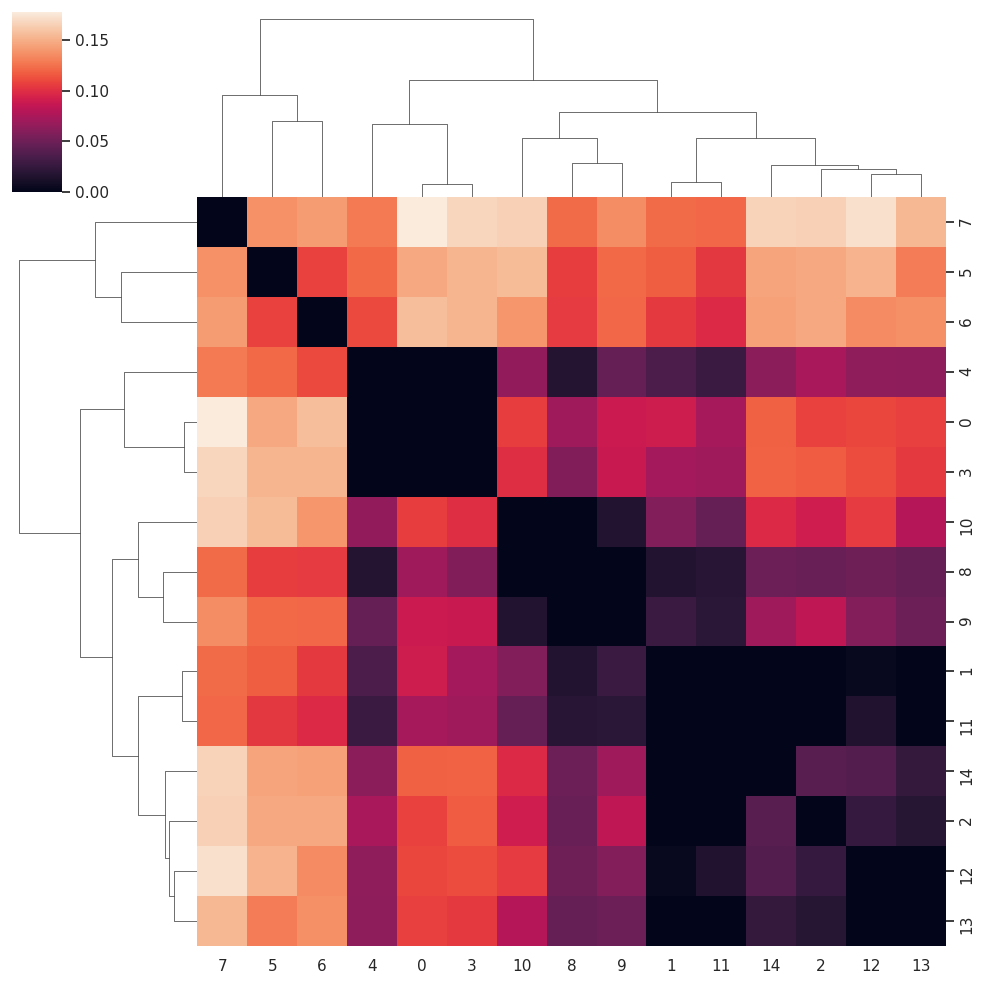

In [88]:
sns.clustermap(np.nan_to_num(fst_results)[0].clip(min=0))